# KMeans Predictive Cluster Models for Crime Victim Analysis:
## A. C. Coffin 
### 11/10/2023
### Northwestern Missouri State University
### MS Data Analytics Capstone
---
### Introduction:

This section demonstrates the use of one of two clustering algorythms, on Crime Victim Data gathered from the NYPD and the NCVS Dashboard, specifically KMeans. The objective is to determine which model is the most successful at predictive clustering using both data sets, and then beginning a process of incremental learning. By taking the model trained on the NCVS data and fitting NYPD data, it is possible to exicute a process known as incremental learning. As crime data is extremily complex utilizing incremental learning will address inconcistencies that are common with crime data. 
---
## Importing packages and Addressing Threads:

In [4]:
from threadpoolctl import threadpool_info
from pprint import pprint
import numpy
pprint(threadpool_info())


[{'filepath': 'C:\\Users\\Tower\\anaconda3\\Library\\bin\\mkl_rt.1.dll',
  'internal_api': 'mkl',
  'num_threads': 6,
  'prefix': 'mkl_rt',
  'threading_layer': 'intel',
  'user_api': 'blas',
  'version': '2021.4-Product'}]


In [5]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
pprint(threadpool_info())

[{'filepath': 'C:\\Users\\Tower\\anaconda3\\Library\\bin\\mkl_rt.1.dll',
  'internal_api': 'mkl',
  'num_threads': 6,
  'prefix': 'mkl_rt',
  'threading_layer': 'intel',
  'user_api': 'blas',
  'version': '2021.4-Product'},
 {'filepath': 'C:\\Users\\Tower\\anaconda3\\Library\\bin\\libiomp5md.dll',
  'internal_api': 'openmp',
  'num_threads': 12,
  'prefix': 'libiomp',
  'user_api': 'openmp',
  'version': None}]


In [64]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from yellowbrick.cluster import SilhouetteVisualizer
%matplotlib inline

import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("default")

c:\Users\Tower\anaconda3\lib\site-packages\yellowbrick\style\colors.py:35: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  mpl_ge_150 = LooseVersion(mpl.__version__) >= "1.5.0"
c:\Users\Tower\anaconda3\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
c:\Users\Tower\anaconda3\lib\site-packages\yellowbrick\style\rcmod.py:31: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  mpl_ge_150 = LooseVersion(mpl.__version__) >= "1.5.0"


# Pre-Processing:
All of the data within these crime sets is catagorical in nature and as a result was proceed differently. Part of pre-processing was grouping crime types together, as well as removing those which didn't apply to specific models. When addressing the grouping of data within the NYPD dataset, crimes were coordinated based on the general type of crime and severity. The grouping of key codes is explained in the following table, along with thier offense description. The data pulled from the NCVS pertains to mainly Personal Crimes, such as sexual assault, robbery, aggrivated assault and simple assault. In order to make the data found within the NYPD data to be compatible with the incremental learning to occur, these crimes were once again grouped and sorted based on the types found in the NCVS data. Data pertaining to age groups has already been seperated, with an adjustment made to the NCVS data to group minors together as that data in particular breaks the age groups apart indepth. All null values found within the NYPD data for age have been removed, it was included within analysis to visualize the amount of known data in comparison to the unknown within the filtered set.

## Modifications Made to both NCVS and NYPD Data:
Please see the following charts for the modified ML sets. Each of these set was exported from the SQL server independently and labeled ML for this specific section of the project. Victims with a listed age of N/A were put into class 6 for Age_GM. This is in response to how depending on the crime victim ages are ommited for safety, espcially since the NYPD data has associated case numbers in the original set. 

Modifications to Age Groups within the NCVS data is as follows:
|AGE_GM|NCVS Age Groups|New Range|
|:---|:---|:---|
|1 |12-14, 15-17| >18|
|2 |18-20, 21-24| 18-25|
|3 |25-34, 35-49| 25-49|
|4 |50-64| 50-64|
|5 | 65+ | 65+|
|5 |Unknown| Unknown|

Modifications to NYPD data as NCIC Codes and CT_M:
|NCIC|KY_CD|OFNS_DESC|CT_M|CT_M Meaning
|:---|:---|:---|:---|:---|
|1011 |104, 115, 116, 235|Sex Crimes| 2| Violent Crime Except Simple Assault|
|1201 |105, 107, 109-113, 231, 313, 340-343| Robbery/Fraud| 2| Violent Crime Except Simple Assault|
|1301 |101, 103, 106, 114| Homicide/Aggrivated Assault| 2| Violent Crime Except Simple Assault|
|1313 |344, 578, 230, 355| Simple Assault/Related Crimes| 1| Simple Assault|

Data pertaining to Public or Society Crimes, such as driving under the influence, traffic violations, child abandonment, pocession of a deadly weapon or drug pocessions have been removed from this data. This was done as the NCVS data pulled only pertains to Personal Crimes. This data was utilized both through the initial run of the models and again when being fitted to the selected NCVS model. The only difference is that when the NYPD data was fitted to the NCVS model the NCIC model was used. This was to demonstrate the differences between the sets as a whole. 

---
# NCVS Baseline:
As this Analysis relies heavily on the comparison of National Data to Regional Data to explore crime in america as well as demonstrate a possible application of machine learning, creating a baseline is critical. For this section each of the models has been run three times on the pre-processed NCVS data. There are two major data sets which will be used, the first being the NCVS_RegionalML Data, and the second being the NCVS_AgeSegML. 

## Importing NCVS Data:
All data for each of the sets being analysize has been brought in independently to decrease processing load.


In [7]:
NCVS_AgeSeg = pd.read_csv('Data/ML_PreProcess/NCVS_AgeSegML.csv', index_col= 'rpt_dt')
NCVS_Region = pd.read_csv('Data/ML_PreProcess/NCVS_RegionSegML.csv', index_col='rpt_dt')


In [8]:
NCVS_AgeSeg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 960 entries, 1993 to 2022
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   age_gm   960 non-null    int64
 1   ncic     960 non-null    int64
 2   vic_num  960 non-null    int64
dtypes: int64(3)
memory usage: 30.0 KB


In [9]:
NCVS_Region.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 432 entries, 1996 to 2022
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   region_m  432 non-null    int64
 1   ncic      432 non-null    int64
 2   vic_num   432 non-null    int64
dtypes: int64(3)
memory usage: 13.5 KB


In [10]:
# file over view
NCVS_AgeSeg.describe()

,age_gm,ncic,vic_num
count,960.000000,960.000000,9.600000e+02
mean,2.625000,1229.000000,1.189906e+05
std,1.317643,85.788498,1.729374e+05
min,1.000000,1101.000000,0.000000e+00
25%,1.750000,1176.000000,2.345025e+04
50%,2.500000,1251.000000,5.639350e+04
75%,3.250000,1304.000000,1.287462e+05
max,5.000000,1313.000000,1.286595e+06


# Scaling data:

In [11]:
# Dropping rows with NA values in any columns
NCVS_AgeSeg.dropna(inplace=True)

# Creating a scaled df where each value has a mean of 0 and stdev of 1
from sklearn import preprocessing
scaler = StandardScaler()
NCVS_AgeSeg[["age_gm_T", "ncic_T", "vic_num_T"]] = scaler.fit_transform(NCVS_AgeSeg[["age_gm", "ncic", "vic_num"]])


In [12]:
NCVS_AgeSeg

,age_gm,ncic,vic_num,age_gm_T,ncic_T,vic_num_T
rpt_dt,,,,,,
1993,1,1101,47196,-1.233905,-1.492819,-0.415364
1994,1,1101,49561,-1.233905,-1.492819,-0.401682
1995,1,1101,38205,-1.233905,-1.492819,-0.467381
1996,1,1101,28399,-1.233905,-1.492819,-0.524113
1997,1,1101,50766,-1.233905,-1.492819,-0.394710
...,...,...,...,...,...,...
2018,5,1313,101597,1.803400,0.979663,-0.100630
2019,5,1313,81683,1.803400,0.979663,-0.215841
2020,5,1313,66542,1.803400,0.979663,-0.303439


In [13]:
# Dropping rows with NA values in any columns
NCVS_Region.dropna(inplace=True)

# Creating a scaled df where each value has a mean of 0 and stdev of 1
from sklearn import preprocessing
scaler = StandardScaler()
NCVS_Region[["region_m_T", "ncic_T", "vic_num_T"]] = scaler.fit_transform(NCVS_Region[["region_m", "ncic", "vic_num"]])

#Review scaled rows of the df
print(NCVS_Region)

        region_m  ncic  vic_num  region_m_T    ncic_T  vic_num_T
rpt_dt                                                          
1996           2  1101   145675   -0.447214 -1.492819  -0.290022
1997           2  1101   210209   -0.447214 -1.492819  -0.023054
1998           2  1101   120428   -0.447214 -1.492819  -0.394465
1999           2  1101   143786   -0.447214 -1.492819  -0.297837
2000           2  1101    64034   -0.447214 -1.492819  -0.627759
...          ...   ...      ...         ...       ...        ...
2018           1  1313   264179   -1.341641  0.979663   0.200212
2019           1  1313   297763   -1.341641  0.979663   0.339144
2020           1  1313   203401   -1.341641  0.979663  -0.051218
2021           1  1313   201060   -1.341641  0.979663  -0.060902
2022           1  1313   382218   -1.341641  0.979663   0.688522

[432 rows x 6 columns]


## K-Means Model:
There are a number of clustering models used for data anlysis, one of these models is the kmeans model. The objective of the model is to assign data points to clusters, based on proximity to a centroid. By doing so it explores the association between data points based on distance calculations between groups. The model opperates under the assumption that the cluster is spherical in nature, equally size and has similar dencities. Analysizing crime statistics as well as conceptualizing the actual precence of crime in US society, clustering is often used. The reason is that crime classifications are based on a group of characteristics that are requried for a crime to be considered one class or another. As this data is based on catagorical structure, as opposed to an interval clustering is possible. It is important to note that while in the case of crime, is that while Offenses do carry an ordinal weight within socity, this weight is difficult to build into a model without adding an extra layer or catagory. 

K-Means has limitations, as it performs poorly when clusters are irregular in size, shape and decnity. As the alogrythem itself is based on distance calculations from a centroid, it can be sensitive to the initial placement of a cluster, and even interpret outliers with greater impact than necessary. This is why the analysis begins with K-Means but has an added layer with DBSCAN. 

# Age Segmentation:

In [14]:
# Estimating the number of clusters using KMeans:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

def optimise_k_means(data, max_k):
    means = []
    inertias = []

    for k in range(1, max_k):
        kmeans=KMeans(n_clusters=k)
        kmeans.fit(data)

        means.append(k)
        inertias.append(kmeans.inertia_)

    #Generate the plot
    fig = plt.subplots(figsize=(10, 5))
    plt.plot(means, inertias, '|-')
    plt.title('NCVS AgeSeg Elbow Method')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show()

c:\Users\Tower\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Tower\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Tower\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Tower\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Tower\anaconda3\lib\site-packages\sklearn\clust

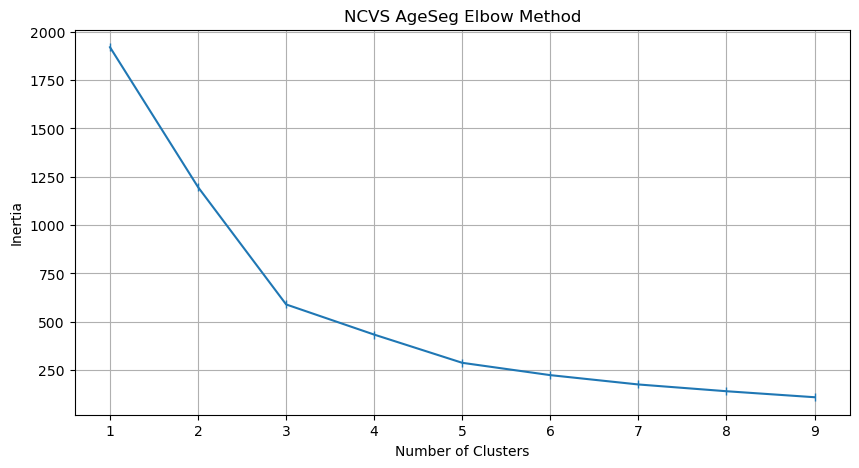

In [15]:
optimise_k_means(NCVS_AgeSeg[['age_gm_T', 'vic_num_T']], 10)

Based on the elbow provided, the number of clusters appropriate to use with this data is 4.

## Applying K-Means

In [55]:
# Creating the model to analysize the data:
kmeansAG= KMeans(n_clusters=4)


In [56]:
kmeansAG.fit(NCVS_AgeSeg[['age_gm_T', 'vic_num_T']])

c:\Users\Tower\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=4)

In [57]:
NCVS_AgeSeg['kmeans_4'] = kmeansAG.labels_
NCVS_AgeSeg

,age_gm,ncic,vic_num,age_gm_T,ncic_T,vic_num_T,kmeans_4,KMeans_1,KMeans_2,KMeans_3,KMeans_4,KMeans_5
rpt_dt,,,,,,,,,,,,
1993,1,1101,47196,-1.233905,-1.492819,-0.415364,1,0,1,2,0,3
1994,1,1101,49561,-1.233905,-1.492819,-0.401682,1,0,1,2,0,3
1995,1,1101,38205,-1.233905,-1.492819,-0.467381,1,0,1,2,0,3
1996,1,1101,28399,-1.233905,-1.492819,-0.524113,1,0,1,2,0,3
1997,1,1101,50766,-1.233905,-1.492819,-0.394710,1,0,1,2,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...
2018,5,1313,101597,1.803400,0.979663,-0.100630,0,0,0,0,1,2
2019,5,1313,81683,1.803400,0.979663,-0.215841,0,0,0,0,1,2
2020,5,1313,66542,1.803400,0.979663,-0.303439,0,0,0,0,1,2


## Scatter Plot of Data:

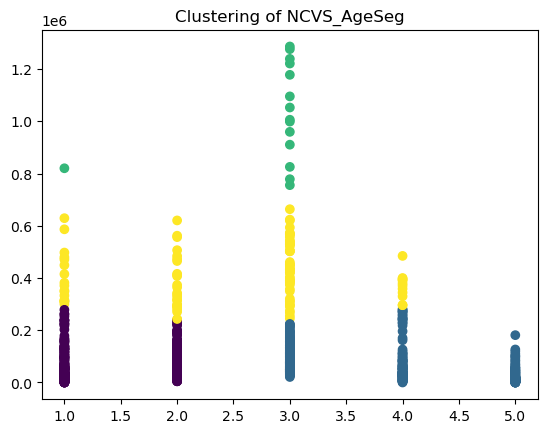

In [19]:
# Creating a kmeans scatter:
plt.scatter(x=NCVS_AgeSeg['age_gm'], y=NCVS_AgeSeg['vic_num'], c=NCVS_AgeSeg['kmeans_4'])
plt.title("Clustering of NCVS_AgeSeg")
plt.show()

# Broken Down Scatter Plot for 4 Clusters NCVS_AgeSeg:

In [76]:
#Silhouette Score
# Establishing x and y
x = NCVS_AgeSeg.iloc[:, :-1].values
y = NCVS_AgeSeg.iloc[:, 1]

model = KMeans(n_clusters = 5, init='k-means++', max_iter=300, n_init=10, random_state=0)
y_means = model.fit_predict(x)


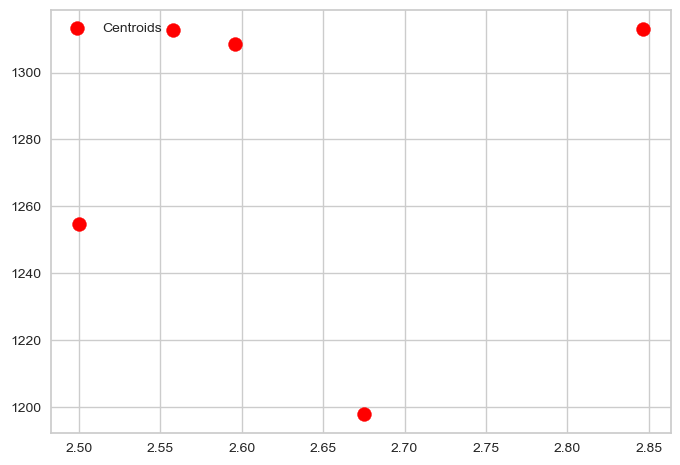

In [77]:
# Creating Plt
plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], s=100, c='red', label='Centroids')
plt.legend()

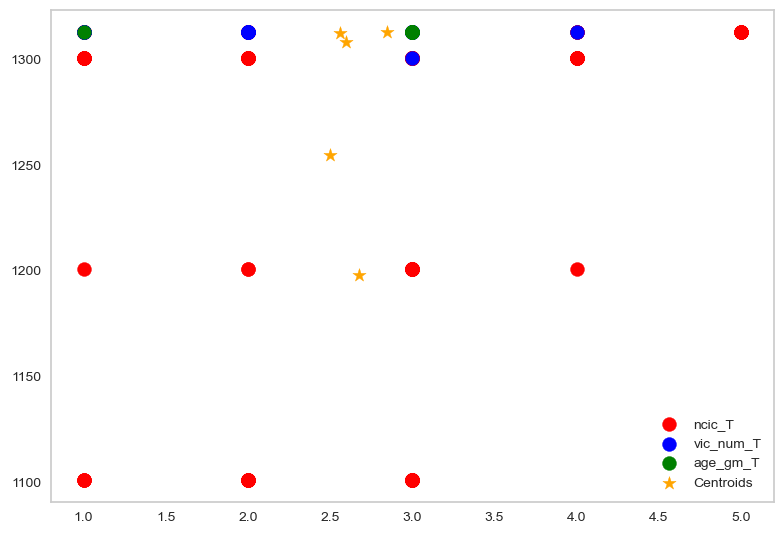

In [78]:
plt.scatter(x[y_means == 0,0], x[y_means==0, 1], s = 100, c='red', label='ncic_T')
plt.scatter(x[y_means == 1,0], x[y_means == 1,1], s=100, c='blue', label='vic_num_T')
plt.scatter(x[y_means == 2,0], x[y_means == 2,1], s=100, c='green', label='age_gm_T')
plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], s=100, c='orange', marker="*", label='Centroids')
plt.legend()
plt.grid()
plt.tight_layout()

In [79]:
# Sihouette score
silhouette_score_average = silhouette_score(x, model.predict(x))
print(silhouette_score_average)

0.6290072138230275


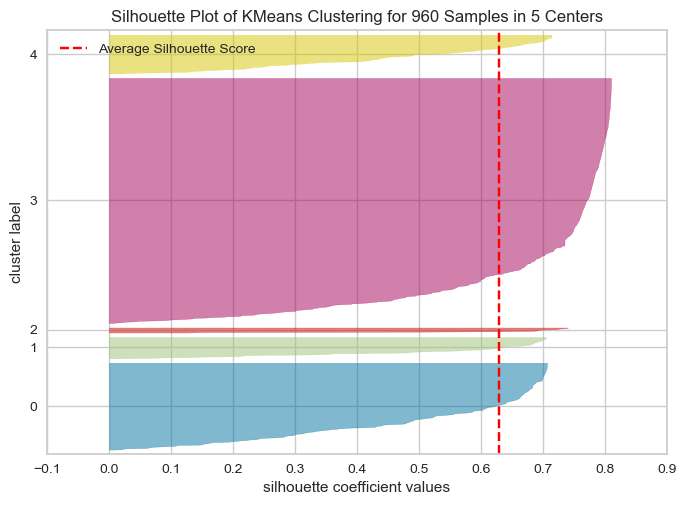

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 960 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [80]:
# Creating a visual of Sihouette:
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(x)
visualizer.show()


# Silhouette:
When examining how the data is clustering for the NCVS_AgeSeg, it simportant to note that a majority of the data falls into the 3rd cluster when examining a 5 cluster model. While 4 is considered the optimal number of clusters according to the Elbow method. However, when examining the Silhouette score of the clustering the number of clusters that performs better is actually 5 as more of the clusters are above the average silhouette score. 

# NCVS_AgeSeg data exploring other values of k

In [23]:
# Splitting using different K values
for k in range(1, 6):
    kmeans=KMeans(n_clusters=k)
    kmeans.fit(NCVS_AgeSeg[['age_gm_T', 'vic_num_T']])
    NCVS_AgeSeg[f'KMeans_{k}'] = kmeans.labels_

c:\Users\Tower\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Tower\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Tower\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Tower\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Tower\anaconda3\lib\site-packages\sklearn\clust

In [24]:
NCVS_AgeSeg

,age_gm,ncic,vic_num,age_gm_T,ncic_T,vic_num_T,kmeans_4,KMeans_1,KMeans_2,KMeans_3,KMeans_4,KMeans_5
rpt_dt,,,,,,,,,,,,
1993,1,1101,47196,-1.233905,-1.492819,-0.415364,0,0,1,2,0,3
1994,1,1101,49561,-1.233905,-1.492819,-0.401682,0,0,1,2,0,3
1995,1,1101,38205,-1.233905,-1.492819,-0.467381,0,0,1,2,0,3
1996,1,1101,28399,-1.233905,-1.492819,-0.524113,0,0,1,2,0,3
1997,1,1101,50766,-1.233905,-1.492819,-0.394710,0,0,1,2,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...
2018,5,1313,101597,1.803400,0.979663,-0.100630,1,0,0,0,1,2
2019,5,1313,81683,1.803400,0.979663,-0.215841,1,0,0,0,1,2
2020,5,1313,66542,1.803400,0.979663,-0.303439,1,0,0,0,1,2


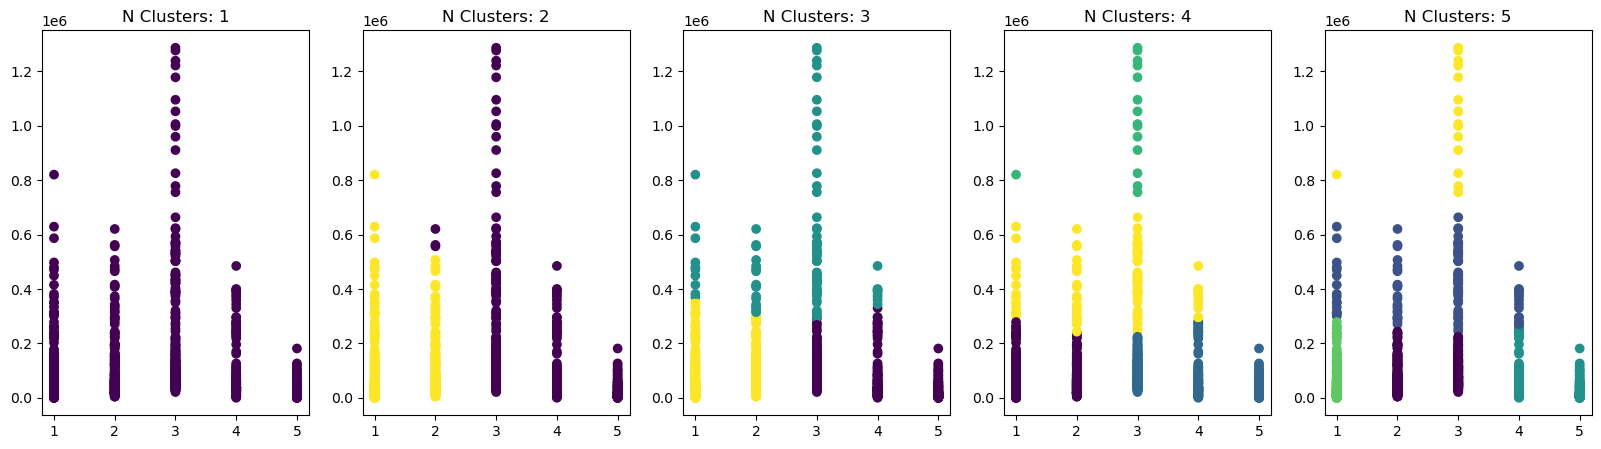

In [25]:
# Sub plots
%matplotlib inline
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20,5))
for i, ax in enumerate(fig.axes, start=1):
    ax.scatter(x=NCVS_AgeSeg['age_gm'], y=NCVS_AgeSeg['vic_num'], c=NCVS_AgeSeg[f'KMeans_{i}'])
    ax.set_title(f'N Clusters: {i}')

As noted the data in this case doesn't cluster well as there are too few data instances accross the age groups to perform this type of analysis. Additionally as all of this data is drastic when comparing age groups to the number of victims, when scaling is applied it distorts the data. As this is a simple data set, the clustering does take the from of bars, this is because there are 5 age groups, as well as the fact that the data has very few entries and is focused as a total number of victims rather than independent entries. 

## Regional KMeans based on NCVS Data

In [27]:
# Estimating the number of clusters using KMeans:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

def optimise_k_means(data, max_k):
    means = []
    inertias = []

    for k in range(1, max_k):
        kmeans=KMeans(n_clusters=k)
        kmeans.fit(data)

        means.append(k)
        inertias.append(kmeans.inertia_)

    #Generate the plot
    fig = plt.subplots(figsize=(10, 5))
    plt.plot(means, inertias, '|-')
    plt.title('NCVS Region Elbow Method')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show()

c:\Users\Tower\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Tower\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Tower\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Tower\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Tower\anaconda3\lib\site-packages\sklearn\clust

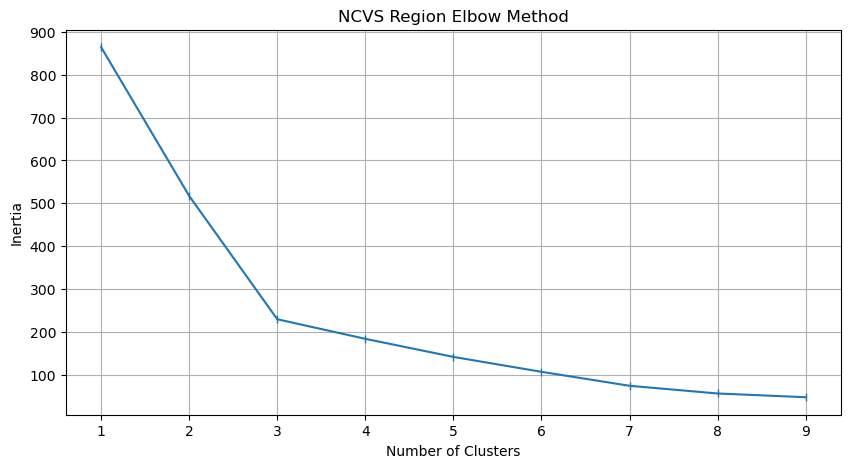

In [28]:
optimise_k_means(NCVS_Region[['region_m_T', 'vic_num_T']], 10)

Optimal number of clusters is 3.

In [29]:
# Creating the model to analysize the data:
kmeans= KMeans(n_clusters=3)



In [30]:
# fitting data to model based on region and number of victims
kmeans.fit(NCVS_Region[['region_m_T', 'vic_num_T']])

# establishing kmeans column
NCVS_Region['kmeans_3'] = kmeans.labels_
NCVS_Region

c:\Users\Tower\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,region_m,ncic,vic_num,region_m_T,ncic_T,vic_num_T,kmeans_3
rpt_dt,,,,,,,
1996,2,1101,145675,-0.447214,-1.492819,-0.290022,0
1997,2,1101,210209,-0.447214,-1.492819,-0.023054,0
1998,2,1101,120428,-0.447214,-1.492819,-0.394465,0
1999,2,1101,143786,-0.447214,-1.492819,-0.297837,0
2000,2,1101,64034,-0.447214,-1.492819,-0.627759,0
...,...,...,...,...,...,...,...
2018,1,1313,264179,-1.341641,0.979663,0.200212,0
2019,1,1313,297763,-1.341641,0.979663,0.339144,0
2020,1,1313,203401,-1.341641,0.979663,-0.051218,0


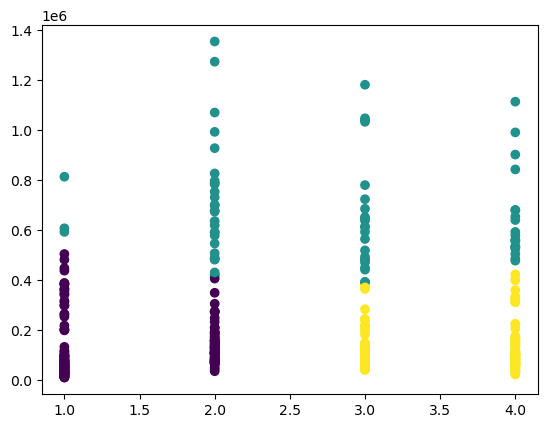

In [31]:
# Creating a kmeans scatter:
plt.scatter(x=NCVS_Region['region_m'], y=NCVS_Region['vic_num'], c=NCVS_Region['kmeans_3'])
plt.show()

In [32]:
for k in range(1, 6):
    kmeans=KMeans(n_clusters=k)
    kmeans.fit(NCVS_Region[['region_m_T', 'vic_num_T']])
    NCVS_Region[f'KMeans_{k}'] = kmeans.labels_

c:\Users\Tower\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Tower\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Tower\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Tower\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Tower\anaconda3\lib\site-packages\sklearn\clust

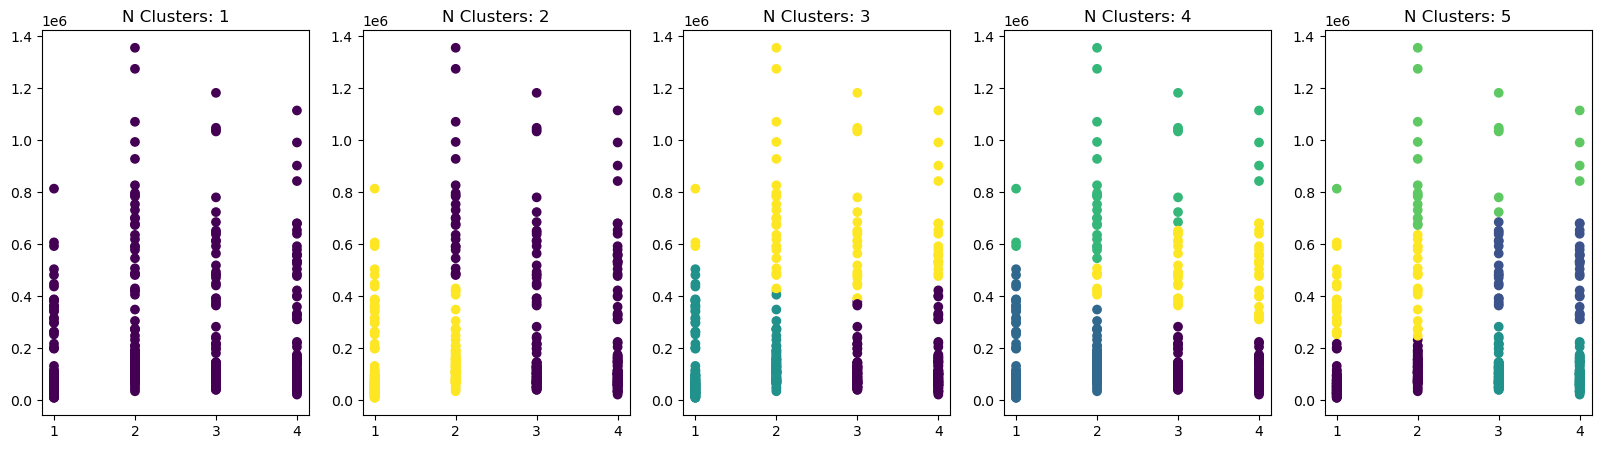

In [33]:
# Sub plots
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20,5))
for i, ax in enumerate(fig.axes, start=1):
    ax.scatter(x=NCVS_Region['region_m'], y=NCVS_Region['vic_num'], c=NCVS_Region[f'KMeans_{i}'])
    ax.set_title(f'N Clusters: {i}')

In [68]:

#Silhouette Score
# Establishing x and y
x = NCVS_Region.iloc[:, :-1].values
y = NCVS_Region.iloc[:, 1]

model = KMeans(n_clusters = 4, init='k-means++', max_iter=300, n_init=10, random_state=0)
y_means = model.fit_predict(x)

# Sihouette score
silhouette_score_average = silhouette_score(x, model.predict(x))
print(silhouette_score_average)

0.7297313965348892


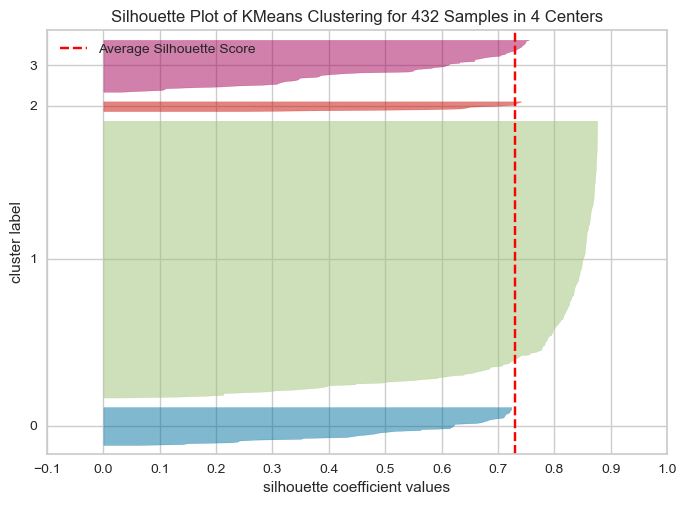

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 432 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [69]:
# Creating a visual of Sihouette:
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(x)
visualizer.show()

## Silhouette of NCVS Region:
While when initially plotting inertia the data indicated that 3 clusters would yield better results, in reality the use of 6 clusters, is more effective. Even though the data is not evenly disperced. This is because the shape of the data is less of a circular cluster and more of a bar, which is more appropriatly analysize using DBSCAN. However, when utilizing 6 clusters there is a lot of encroachment between the clusters and isn't effective.


# NYPD Models:
The data for the NYPD models will be used from the NYPDv4ML file. This file has been cleaned but hasn't been narrowed in scope as much as the data used by the NCVS data. It is important to remember that the catagories that the NCVS data covers is considerably smaller, and results in a less dispersed scatter plot. Where as the NYPD Data has a larger amount of variation as the subclasses of these crimes have been kept. 

# K-Means Analysis:

In [34]:
NYPD = pd.read_csv('Data/ML_PreProcess/NYPDv4ML.csv', index_col= 'rpt_num')


C:\Users\Tower\AppData\Local\Temp\ipykernel_8504\3777620182.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  NYPD = pd.read_csv('Data/ML_PreProcess/NYPDv4ML.csv', index_col= 'rpt_num')


In [35]:
NYPD.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87024 entries, 261177965 to 268067163H1
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   addr_pct_cd               87024 non-null  int64  
 1   boro_nm                   87024 non-null  object 
 2   boro_num                  87024 non-null  int64  
 3   rpt_fr_de                 87024 non-null  object 
 4   rpt_fr_dtm                87024 non-null  int64  
 5   crm_atpt_cptd_cd          87024 non-null  object 
 6   ky_cd                     87024 non-null  int64  
 7   ct_m                      87024 non-null  int64  
 8   ncic                      87024 non-null  int64  
 9   ofns_desc                 87024 non-null  object 
 10  pd_cd                     87003 non-null  float64
 11  pd_desc                   87024 non-null  object 
 12  age_group                 87024 non-null  object 
 13  age_gm                    87024 non-null  int64  
 1

In [36]:
NYPD.head()

,addr_pct_cd,boro_nm,boro_num,rpt_fr_de,rpt_fr_dtm,crm_atpt_cptd_cd,ky_cd,ct_m,ncic,ofns_desc,pd_cd,pd_desc,age_group,age_gm,x_coord_cd,y_coord_cd,lat,lon,lat_lon,new georeferenced column
rpt_num,,,,,,,,,,,,,,,,,,,,
261177965,17,MANHATTAN,1,12/31/2022,44926,COMPLETED,578,1,1313,HARRASSMENT 2,637.0,"HARASSMENT,SUBD 1,CIVILIAN",UNKNOWN,6,991717,214547,40.755557,-73.973048,"(40.755557, -73.973048)",POINT (-73.973048 40.755557)
261196077,75,BROOKLYN,2,1/1/2023,44927,COMPLETED,578,1,1313,HARRASSMENT 2,637.0,"HARASSMENT,SUBD 1,CIVILIAN",UNKNOWN,6,1014120,181866,40.665808,-73.892329,"(40.665808, -73.892329)",POINT (-73.892329 40.665808)
261233709,81,BROOKLYN,2,1/2/2023,44928,COMPLETED,578,1,1313,HARRASSMENT 2,638.0,"HARASSMENT,SUBD 3,4,5",UNKNOWN,6,1002234,191029,40.690991,-73.935150,"(40.690991, -73.93515)",POINT (-73.93515 40.690991)
261236460,67,BROOKLYN,2,1/2/2023,44928,COMPLETED,578,1,1313,HARRASSMENT 2,637.0,"HARASSMENT,SUBD 1,CIVILIAN",UNKNOWN,6,1005061,181044,40.663578,-73.924986,"(40.663578, -73.924986)",POINT (-73.924986 40.663578)
261253958,73,BROOKLYN,2,1/2/2023,44928,COMPLETED,578,1,1313,HARRASSMENT 2,638.0,"HARASSMENT,SUBD 3,4,5",UNKNOWN,6,1005994,182105,40.666486,-73.921619,"(40.666486, -73.921619)",POINT (-73.921619 40.666486)


In [37]:
# Dropping rows with NA values in any columns
NYPD.dropna(inplace=True)

# Creating a scaled df where each value has a mean of 0 and stdev of 1
from sklearn import preprocessing
scaler = StandardScaler()
NYPD[["age_gm_T", "ky_cd_T", "addr_pct_cd_T", "rpt_fr_dtm_T"]] = scaler.fit_transform(NYPD[["age_gm", "ky_cd", "addr_pct_cd", "rpt_fr_dtm"]])


## Determining the Number of Clusters

In [38]:
# Estimating the number of clusters using KMeans:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

def optimise_k_means(data, max_k):
    means = []
    inertias = []

    for k in range(1, max_k):
        kmeans=KMeans(n_clusters=k)
        kmeans.fit(data)

        means.append(k)
        inertias.append(kmeans.inertia_)

    #Generate the plot
    fig = plt.subplots(figsize=(10, 5))
    plt.plot(means, inertias, '|-')
    plt.title('NYPD Elbow Method')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show()

c:\Users\Tower\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Tower\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Tower\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Tower\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Tower\anaconda3\lib\site-packages\sklearn\clust

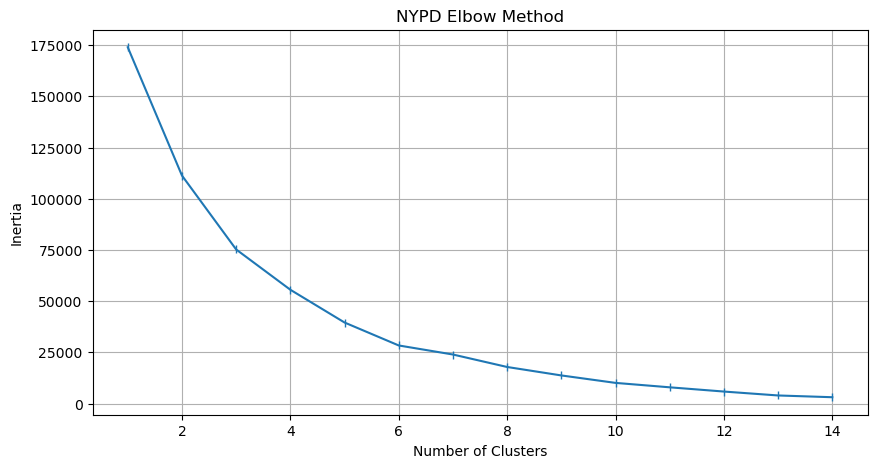

In [39]:
optimise_k_means(NYPD[['ky_cd_T', 'age_gm_T']], 15)

# NYPD Number of Clusters according to Elbow:
In this instance the number of clusters suggested by the graph is 7 clusters. 

In [40]:
# Creating the model to analysize the data: Examining Date and key code relationship
kmeans= KMeans(n_clusters=6)

# fitting data to model based on crime code and age
kmeans.fit(NYPD[['ky_cd_T', 'age_gm_T']])

# establishing kmeans column
NYPD['kmeans_6'] = kmeans.labels_
NYPD

c:\Users\Tower\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,addr_pct_cd,boro_nm,boro_num,rpt_fr_de,rpt_fr_dtm,crm_atpt_cptd_cd,ky_cd,ct_m,ncic,ofns_desc,...,y_coord_cd,lat,lon,lat_lon,new georeferenced column,age_gm_T,ky_cd_T,addr_pct_cd_T,rpt_fr_dtm_T,kmeans_6
rpt_num,,,,,,,,,,,,,,,,,,,,,
261177965,17,MANHATTAN,1,12/31/2022,44926,COMPLETED,578,1,1313,HARRASSMENT 2,...,214547,40.755557,-73.973048,"(40.755557, -73.973048)",POINT (-73.973048 40.755557),2.757959,1.285831,-1.417985,-0.234915,1
261196077,75,BROOKLYN,2,1/1/2023,44927,COMPLETED,578,1,1313,HARRASSMENT 2,...,181866,40.665808,-73.892329,"(40.665808, -73.892329)",POINT (-73.892329 40.665808),2.757959,1.285831,0.299215,-0.231328,1
261233709,81,BROOKLYN,2,1/2/2023,44928,COMPLETED,578,1,1313,HARRASSMENT 2,...,191029,40.690991,-73.935150,"(40.690991, -73.93515)",POINT (-73.93515 40.690991),2.757959,1.285831,0.476856,-0.227740,1
261236460,67,BROOKLYN,2,1/2/2023,44928,COMPLETED,578,1,1313,HARRASSMENT 2,...,181044,40.663578,-73.924986,"(40.663578, -73.924986)",POINT (-73.924986 40.663578),2.757959,1.285831,0.062359,-0.227740,1
261253958,73,BROOKLYN,2,1/2/2023,44928,COMPLETED,578,1,1313,HARRASSMENT 2,...,182105,40.666486,-73.921619,"(40.666486, -73.921619)",POINT (-73.921619 40.666486),2.757959,1.285831,0.240001,-0.227740,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270480486,45,BRONX,3,6/27/2023,45104,COMPLETED,104,2,1101,RAPE,...,241976,40.830722,-73.827126,"(40.8307223277672, -73.8271260588639)",POINT (-73.8271260588639 40.8307223277672),-2.102452,-1.363989,-0.588992,0.403591,3
270630213,83,BROOKLYN,2,9/1/2022,44805,COMPLETED,104,2,1101,RAPE,...,193757,40.698474,-73.917769,"(40.6984738177025, -73.917768981221)",POINT (-73.917768981221 40.6984738177025),-2.102452,-1.363989,0.536070,-0.668955,3
270643747,47,BRONX,3,6/20/2022,44732,COMPLETED,104,2,1101,RAPE,...,262584,40.887314,-73.847272,"(40.8873136344706, -73.8472717577564)",POINT (-73.8472717577564 40.8873136344706),-2.102452,-1.363989,-0.529778,-0.930814,3


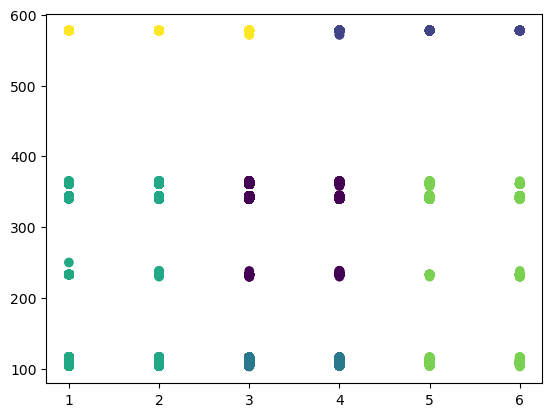

In [41]:
# Creating a kmeans scatter:
%matplotlib inline
plt.scatter(x=NYPD['age_gm'], y=NYPD['ky_cd'], c=NYPD['kmeans_6'])
plt.show()

In [42]:
for k in range(1, 6):
    kmeans=KMeans(n_clusters=k)
    kmeans.fit(NYPD[['age_gm_T', 'ky_cd_T']])
    NYPD[f'KMeans_{k}'] = kmeans.labels_

c:\Users\Tower\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Tower\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Tower\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Tower\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Tower\anaconda3\lib\site-packages\sklearn\clust

KeyError: 'KMeans_6'

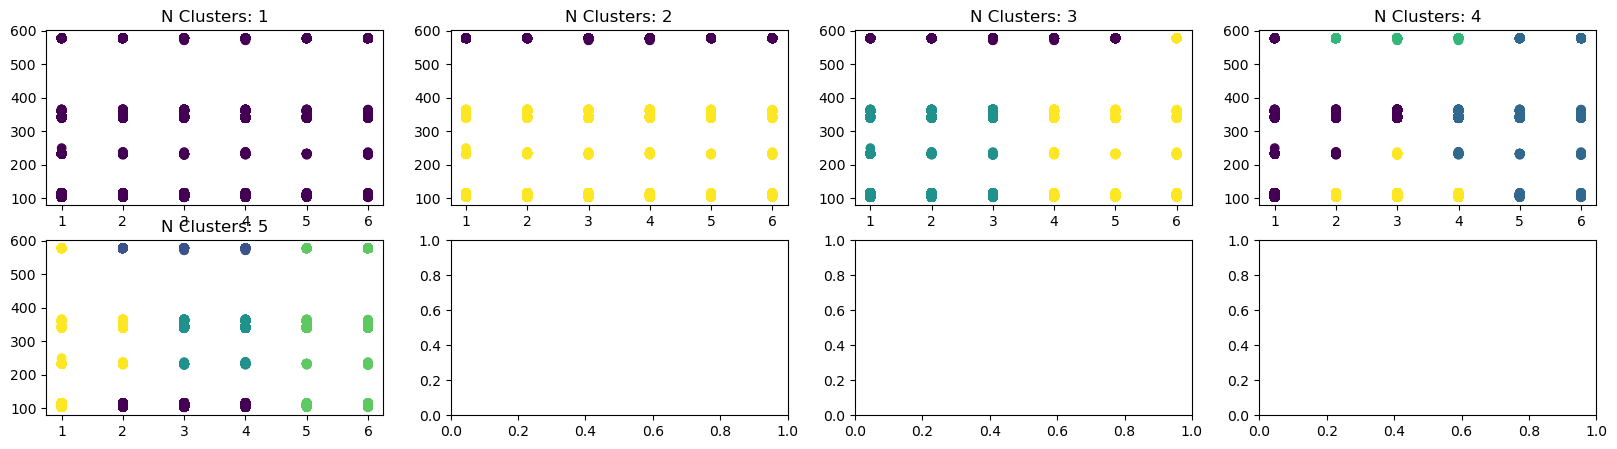

In [43]:
# Sub plots
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20,5))
for i, ax in enumerate(fig.axes, start=1):
    ax.scatter(x=NYPD['age_gm'], y=NYPD['ky_cd'], c=NYPD[f'KMeans_{i}'])
    ax.set_title(f'N Clusters: {i}')

In [44]:
NYPD.columns

Index(['addr_pct_cd', 'boro_nm', 'boro_num', 'rpt_fr_de', 'rpt_fr_dtm',
       'crm_atpt_cptd_cd', 'ky_cd', 'ct_m', 'ncic', 'ofns_desc', 'pd_cd',
       'pd_desc', 'age_group', 'age_gm', 'x_coord_cd', 'y_coord_cd', 'lat',
       'lon', 'lat_lon', 'new georeferenced column', 'age_gm_T', 'ky_cd_T',
       'addr_pct_cd_T', 'rpt_fr_dtm_T', 'kmeans_6', 'KMeans_1', 'KMeans_2',
       'KMeans_3', 'KMeans_4', 'KMeans_5', 'KMeans_6', 'KMeans_7'],
      dtype='object')

In [44]:
# Creating df for silhouette:
selected_columns = ['age_gm_T', 'ky_cd_T', 'addr_pct_cd_T', 'rpt_fr_dtm_T']
new_NYPD = NYPD[selected_columns].copy()

In [45]:
new_NYPD

,age_gm_T,ky_cd_T,addr_pct_cd_T,rpt_fr_dtm_T
rpt_num,,,,
261177965,2.757959,1.285831,-1.417985,-0.234915
261196077,2.757959,1.285831,0.299215,-0.231328
261233709,2.757959,1.285831,0.476856,-0.227740
261236460,2.757959,1.285831,0.062359,-0.227740
261253958,2.757959,1.285831,0.240001,-0.227740
...,...,...,...,...
270480486,-2.102452,-1.363989,-0.588992,0.403591
270630213,-2.102452,-1.363989,0.536070,-0.668955
270643747,-2.102452,-1.363989,-0.529778,-0.930814


In [70]:
#Silhouette Score
# Establishing x and y
x = new_NYPD.iloc[:, :-1].values
y = new_NYPD.iloc[:, 1]

model2 = KMeans(n_clusters = 6, init='k-means++', max_iter=300, n_init=10, random_state=0)
y_means = model2.fit_predict(x)



In [71]:
# Sihouette score
silhouette_score_average = silhouette_score(x, model2.predict(x))
print(silhouette_score_average)

0.2988734061510894


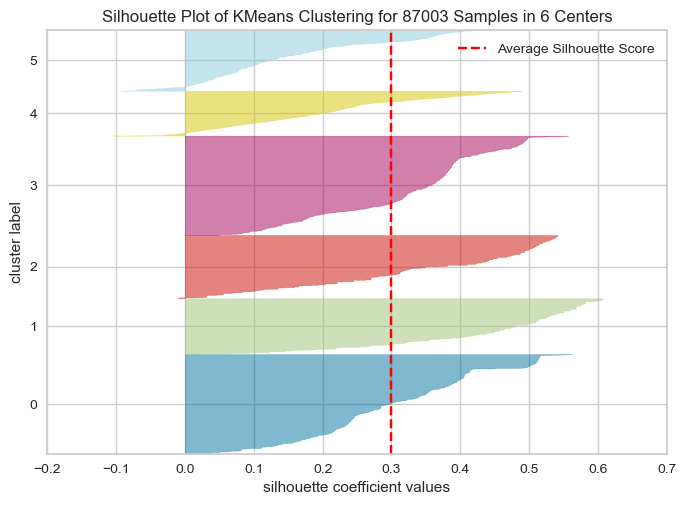

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 87003 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [72]:
# Creating a visual of Sihouette:
visualizer = SilhouetteVisualizer(model2, colors='yellowbrick')
visualizer.fit(x)
visualizer.show()

# Modified NYPD Data:
This section is to demonstrate the impact that data format has on analysis and constructing models. Many different States and Cities provide an anual or quarterly summary, which does provide information, however, the format of this data can affect the performance of the model.

In [85]:
NYPD_AgeSeg = pd.read_csv('Data/ML_PreProcess/NYPD_AgeSegML.csv')
NYPD_AgeSeg.drop(['age_group'], axis=1, inplace=(True))
NYPD_AgeSeg

,rpt_dt,age_gm,ncic,ct_m,vic_num
0,2004,1,1101,2,1
1,2009,1,1101,2,1
2,2010,1,1101,2,4
3,2011,1,1101,2,7
4,2012,1,1101,2,11
...,...,...,...,...,...
202,2023,6,1201,2,457
203,2022,6,1301,2,3
204,2023,6,1301,2,435
205,2022,6,1313,1,11


In [87]:
# Scaling the Data:
scaler = StandardScaler()
NYPD_AgeSeg[["age_gm_T", "ncic_T", "vic_num_T"]] = scaler.fit_transform(NYPD_AgeSeg[["age_gm", "ncic", "vic_num"]])
NYPD_AgeSeg

,rpt_dt,age_gm,ncic,ct_m,vic_num,age_gm_T,ncic_T,vic_num_T
0,2004,1,1101,2,1,-1.573094,-1.023053,-0.229145
1,2009,1,1101,2,1,-1.573094,-1.023053,-0.229145
2,2010,1,1101,2,4,-1.573094,-1.023053,-0.227506
3,2011,1,1101,2,7,-1.573094,-1.023053,-0.225867
4,2012,1,1101,2,11,-1.573094,-1.023053,-0.223681
...,...,...,...,...,...,...,...,...
202,2023,6,1201,2,457,1.861826,0.085469,0.019993
203,2022,6,1301,2,3,1.861826,1.193990,-0.228052
204,2023,6,1301,2,435,1.861826,1.193990,0.007974
205,2022,6,1313,1,11,1.861826,1.327013,-0.223681


c:\Users\Tower\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Tower\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Tower\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Tower\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Tower\anaconda3\lib\site-packages\sklearn\clust

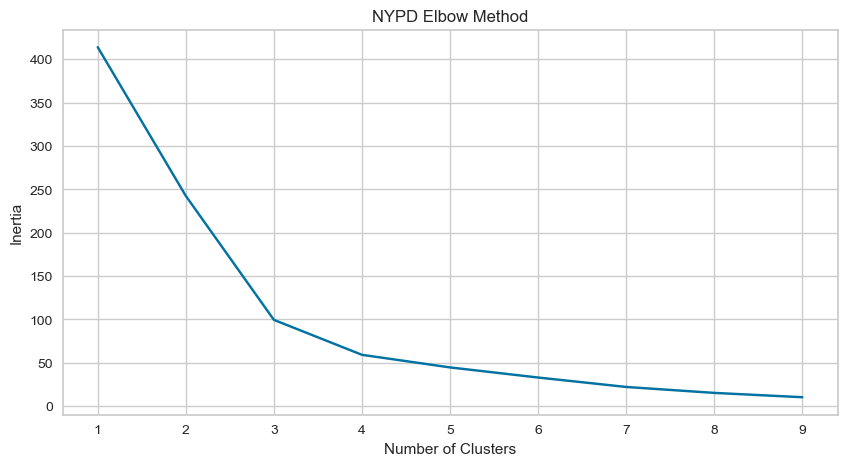

In [88]:
optimise_k_means(NYPD_AgeSeg[['age_gm_T', 'vic_num_T']], 10)

In [95]:
kmeans2= KMeans(n_clusters=3)
kmeans2.fit(NYPD_AgeSeg[['age_gm_T', 'vic_num_T']])

c:\Users\Tower\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3)

In [96]:
NYPD_AgeSeg['kmeans_3'] = kmeans2.labels_
NYPD_AgeSeg

,rpt_dt,age_gm,ncic,ct_m,vic_num,age_gm_T,ncic_T,vic_num_T,kmeans_4,kmeans_3
0,2004,1,1101,2,1,-1.573094,-1.023053,-0.229145,3,0
1,2009,1,1101,2,1,-1.573094,-1.023053,-0.229145,3,0
2,2010,1,1101,2,4,-1.573094,-1.023053,-0.227506,3,0
3,2011,1,1101,2,7,-1.573094,-1.023053,-0.225867,3,0
4,2012,1,1101,2,11,-1.573094,-1.023053,-0.223681,3,0
...,...,...,...,...,...,...,...,...,...,...
202,2023,6,1201,2,457,1.861826,0.085469,0.019993,2,1
203,2022,6,1301,2,3,1.861826,1.193990,-0.228052,2,1
204,2023,6,1301,2,435,1.861826,1.193990,0.007974,2,1
205,2022,6,1313,1,11,1.861826,1.327013,-0.223681,2,1


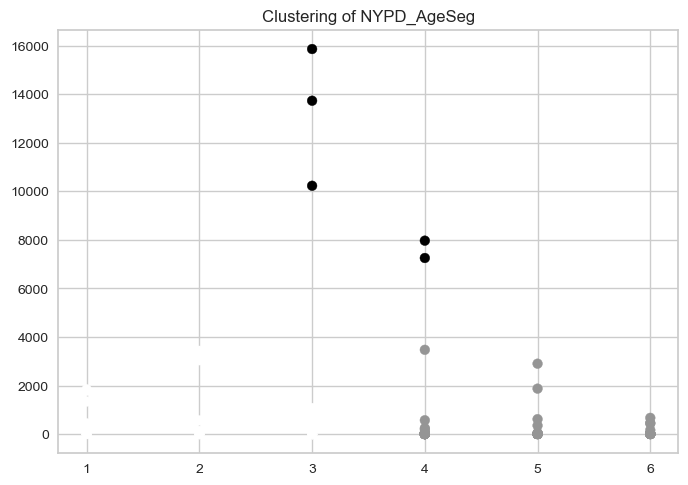

In [97]:
# Creating a kmeans scatter:
plt.scatter(x=NYPD_AgeSeg['age_gm'], y=NYPD_AgeSeg['vic_num'], c=NYPD_AgeSeg['kmeans_3'])
plt.title("Clustering of NYPD_AgeSeg")
plt.show()

In [99]:
#Silhouette Score
# Establishing x and y
x = NYPD_AgeSeg.iloc[:, :-1].values
y = NYPD_AgeSeg.iloc[:, 1]

model3 = KMeans(n_clusters = 3, init='k-means++', max_iter=300, n_init=10, random_state=0)
y_means = model3.fit_predict(x)

In [100]:
# Sihouette score
silhouette_score_average = silhouette_score(x, model3.predict(x))
print(silhouette_score_average)

0.9207414202235482


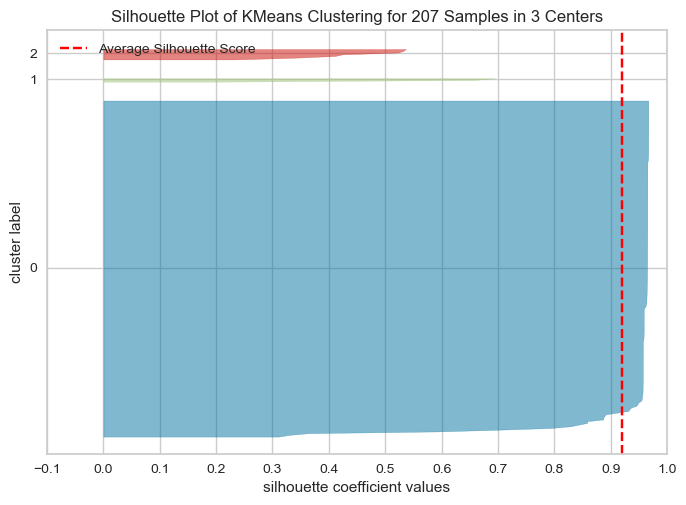

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 207 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [102]:
# Creating a visual of Sihouette:
visualizer = SilhouetteVisualizer(model3, colors='yellowbrick')
visualizer.fit(x)
visualizer.show()